In [88]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.stats import linregress
from particle.literals import tau_minus
import pandas as pd
from particle import width_to_lifetime, lifetime_to_width # MeV <-> ns
import matplotlib.pyplot as plt

mtau = tau_minus.mass # MeV
fa = 1e6 # MeV
speed_light = 29.98 # cm/ns
a_em = 1/137
Gamma0 = lifetime_to_width(1/speed_light)
hbar = lifetime_to_width(1)/1000 # GeV ns
plt.rcParams['text.usetex'] = True

In [2]:
def f(x):
    if x >= 1:
        return np.arcsin(x**-0.5)
    else:
        return np.pi/2+0.5j*np.log((1+(1-x)**0.5)/(1-(1-x)**0.5))
B1 = lambda x: 1-x*f(x)**2+5

def Gamma_photons(ma):
    return a_em**2*ma**3/(fa**2*(4*np.pi)**3)*abs(B1(4*mtau**2/ma**2))**2

In [3]:
def coupling_length_ALP(length, ma, boosted=True):
    s=10.58**2
    mtau0 = mtau/1000
    if boosted:
        boost = (s+ma**2)/(2*np.sqrt(s)*ma)
    else:
        boost = 1
    return np.sqrt((4*np.pi)**3*mtau0**2*hbar*speed_light/(a_em**2*np.abs(B1(4*mtau0**2/ma**2))**2* ma**3*length)*boost)/(mtau*1e-6)

## $e^+e^-\to\tau^+\tau^-\gamma\gamma$

In [4]:
df_taugamma20fb = pd.read_csv("tautaugammagamma_20fbinv.csv")
df_taugamma50ab = pd.read_csv("tautaugammagamma_50abinv.csv")

Text(0, 0.5, '$|c_\\tau|/f_a$')

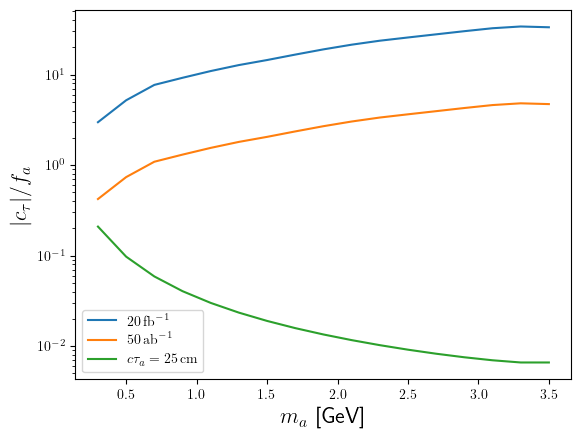

In [5]:
plt.semilogy(df_taugamma20fb['ma_GeV'], df_taugamma20fb['ctau'], label=r'$20\,\mathrm{fb}^{-1}$')
plt.semilogy(df_taugamma50ab['ma_GeV'], df_taugamma50ab['ctau'], label=r'$50\,\mathrm{ab}^{-1}$')
plt.semilogy(df_taugamma20fb['ma_GeV'], [coupling_length_ALP(25, ma, False) for ma in df_taugamma20fb['ma_GeV']], label=r'$c\tau_a = 25\,\mathrm{cm}$')
plt.legend()
plt.xlabel(r'$m_a$ [GeV]', fontsize=16)
plt.ylabel(r'$|c_\tau|/f_a$', fontsize=16)

In [6]:
interp_taugamma_20fb = CubicSpline(df_taugamma20fb['ma_GeV'], df_taugamma20fb['ctau'])
interp_taugamma_50ab = CubicSpline(df_taugamma50ab['ma_GeV'], df_taugamma50ab['ctau'])

In [7]:
bound_taugamma20fb = []
bound_taugamma50ab =[]
for ma in np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200):
    lim_lifetime = coupling_length_ALP(25, ma, False)
    lim_exp20fb = interp_taugamma_20fb(ma)
    lim_exp50ab = interp_taugamma_50ab(ma)
    bound_taugamma20fb.append(max(lim_lifetime, lim_exp20fb))
    bound_taugamma50ab.append(max(lim_lifetime, lim_exp50ab))

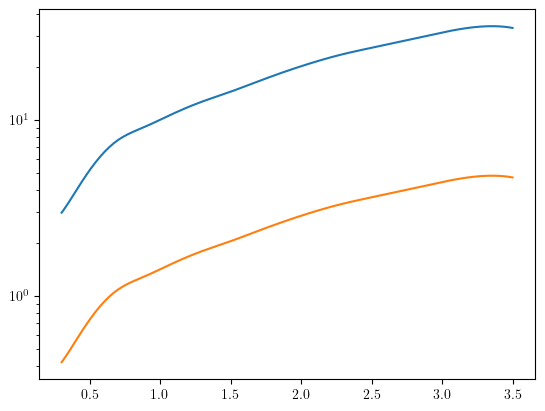

In [8]:
plt.semilogy(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma20fb)
plt.semilogy(np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), bound_taugamma50ab)

In [9]:
pd.DataFrame({'ma_GeV': np.linspace(min(df_taugamma20fb['ma_GeV']), max(df_taugamma20fb['ma_GeV']), 200), 'ctau_20fb-1': bound_taugamma20fb, 'ctau_50ab-1': bound_taugamma50ab}).to_csv('../data/direct_searches/tautaugammagamma_c0.csv')

## $e^+e^-\to 3\gamma$

In [10]:
df_3gamma_20fb = pd.read_csv('3gamma_20fb.csv')
df_3gamma_50ab = pd.read_csv('3gamma_50ab.csv')

(0.1, 100000.0)

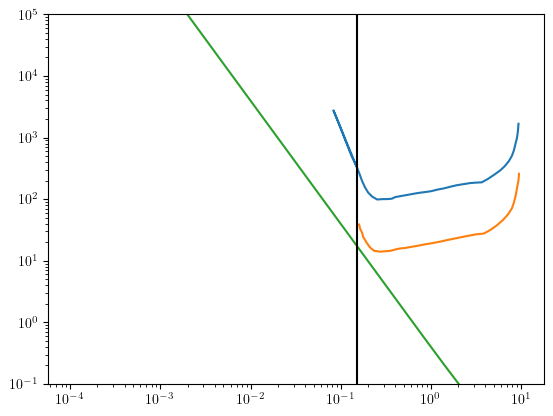

In [11]:
plt.loglog(df_3gamma_20fb['ma_GeV'], df_3gamma_20fb['gtau']/(mtau*1e-6))
plt.loglog(df_3gamma_50ab['ma_GeV'], df_3gamma_50ab['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(1, ma) for ma in np.logspace(-4, 1, 200)])
plt.axvline(0.15, c='k')
plt.ylim(1e-1, 1e5)

In [90]:
df_3gamma_20fb_clean = df_3gamma_20fb.loc[df_3gamma_20fb['ma_GeV']>0.3].loc[df_3gamma_20fb['ma_GeV']<2e-3*mtau].sort_values(by='ma_GeV')
df_3gamma_50ab_clean = df_3gamma_50ab.loc[df_3gamma_50ab['ma_GeV']>0.3].loc[df_3gamma_50ab['ma_GeV']<2e-3*mtau].sort_values(by='ma_GeV')

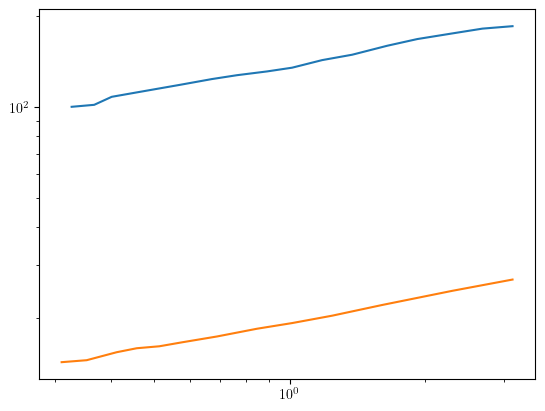

In [91]:
plt.loglog(df_3gamma_20fb_clean['ma_GeV'], df_3gamma_20fb_clean['gtau']/(mtau*1e-6))
plt.loglog(df_3gamma_50ab_clean['ma_GeV'], df_3gamma_50ab_clean['gtau']/(mtau*1e-6))

In [96]:
lreg_3gamma_20fb = linregress(np.log(df_3gamma_20fb_clean['ma_GeV']), np.log(df_3gamma_20fb_clean['gtau']/(mtau*1e-6)))
def interp_3gamma_20fb(ma):
    return np.exp(lreg_3gamma_20fb.slope*np.log(ma)+lreg_3gamma_20fb.intercept)

lreg_3gamma_50ab = linregress(np.log(df_3gamma_50ab_clean['ma_GeV']), np.log(df_3gamma_50ab_clean['gtau']/(mtau*1e-6)))
def interp_3gamma_50ab(ma):
    return np.exp(lreg_3gamma_50ab.slope*np.log(ma)+lreg_3gamma_50ab.intercept)

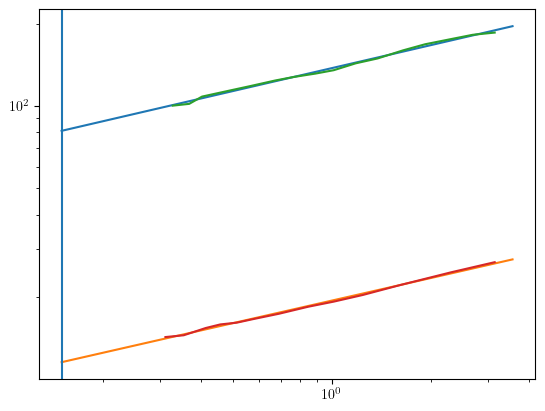

In [97]:
plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)])
plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp_3gamma_50ab(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)])

plt.loglog(df_3gamma_20fb_clean['ma_GeV'], df_3gamma_20fb_clean['gtau']/(mtau*1e-6))
plt.loglog(df_3gamma_50ab_clean['ma_GeV'], df_3gamma_50ab_clean['gtau']/(mtau*1e-6))
plt.axvline(0.15)

In [101]:
ctau_3gamma_20fb = []
for ma in np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_20fb_clean['ma_GeV'])), 5):
    ctau_3gamma_20fb.append(max(coupling_length_ALP(1, ma), interp_3gamma_20fb(ma)))
for ma, gtau in df_3gamma_20fb_clean.values:
    ctau_3gamma_20fb.append(max(coupling_length_ALP(1, ma), gtau/(mtau*1e-6)))

ctau_3gamma_50ab = []
for ma in np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_50ab_clean['ma_GeV'])), 5):
    ctau_3gamma_50ab.append(max(coupling_length_ALP(1, ma), interp_3gamma_50ab(ma)))
for ma, gtau in df_3gamma_50ab_clean.values:
    ctau_3gamma_50ab.append(max(coupling_length_ALP(1, ma), gtau/(mtau*1e-6)))

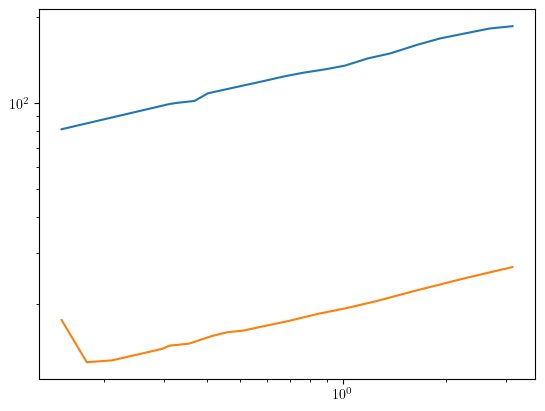

In [102]:
plt.loglog(list(np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_20fb_clean['ma_GeV'])), 5))+list(df_3gamma_20fb_clean['ma_GeV']), ctau_3gamma_20fb)
plt.loglog(list(np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_50ab_clean['ma_GeV'])), 5))+list(df_3gamma_50ab_clean['ma_GeV']), ctau_3gamma_50ab)

In [103]:
interp2_3gamma_20fb = CubicSpline(list(np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_20fb_clean['ma_GeV'])), 5))+list(df_3gamma_20fb_clean['ma_GeV']), ctau_3gamma_20fb)

interp2_3gamma_50ab = CubicSpline(list(np.logspace(np.log10(0.15), np.log10(0.95*np.min(df_3gamma_50ab_clean['ma_GeV'])), 5))+list(df_3gamma_50ab_clean['ma_GeV']), ctau_3gamma_50ab)

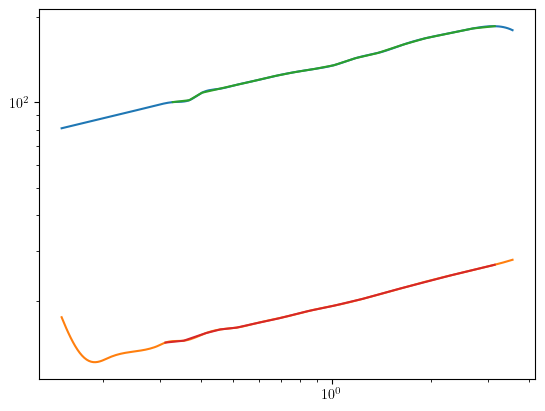

In [106]:
plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp2_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)])

plt.loglog(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp2_3gamma_50ab(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)])

plt.loglog(df_3gamma_20fb_clean['ma_GeV'], df_3gamma_20fb_clean['gtau']/(mtau*1e-6))
plt.loglog(df_3gamma_50ab_clean['ma_GeV'], df_3gamma_50ab_clean['gtau']/(mtau*1e-6))

In [107]:
pd.DataFrame({
    'ma_GeV': np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200),
    'ctau_20fb-1': [interp2_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)],
    'ctau_50ab-1': [interp2_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)[:60]] + [interp_3gamma_50ab(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)[60:]]
}).to_csv('../data/direct_searches/ee3gamma_c0.csv', index=False)

## $e^+e^-\to \gamma +$ inv

In [114]:
df_gammainv_20fb = pd.read_csv('gammainv_20fb.csv')
df_gammainv_50ab = pd.read_csv('gammainv_50ab.csv')

(0.1, 100000.0)

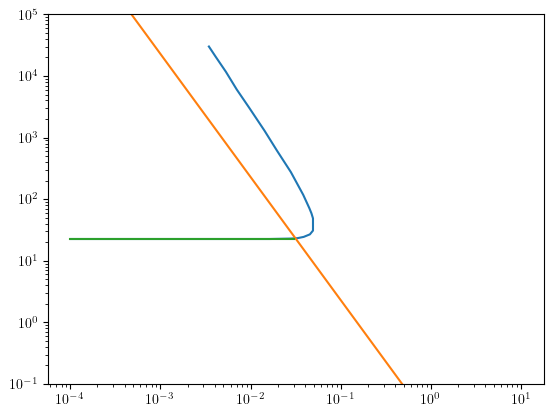

In [110]:
plt.loglog(df_gammainv_20fb['ma_GeV'], df_gammainv_20fb['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, 1, 200)])
plt.plot([1e-4, 3e-2], [df_gammainv_20fb['gtau'][0]/(mtau*1e-6), df_gammainv_20fb['gtau'][0]/(mtau*1e-6)])
plt.ylim(1e-1, 1e5)

(0.1, 100000.0)

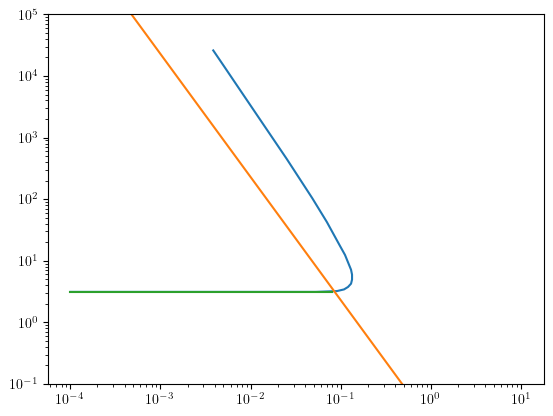

In [118]:
plt.loglog(df_gammainv_50ab['ma_GeV'], df_gammainv_50ab['gtau']/(mtau*1e-6))
plt.loglog(np.logspace(-4, 1, 200), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, 1, 200)])
plt.plot([1e-4, 0.08], [df_gammainv_50ab['gtau'][0]/(mtau*1e-6), df_gammainv_50ab['gtau'][0]/(mtau*1e-6)])
plt.ylim(1e-1, 1e5)

In [119]:
low_gammainv_20fb = [df_gammainv_20fb['gtau'][0]/(mtau*1e-6) if ma<3e-2 else np.nan for ma in np.logspace(-4, np.log10(0.08), 200)]

(0.001, 10)

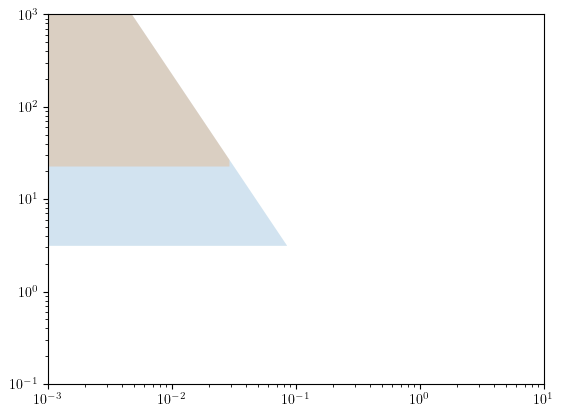

In [121]:

plt.fill_between(np.logspace(-4, np.log10(0.085), 200), df_gammainv_50ab['gtau'][0]/(mtau*1e-6), [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.085), 200)], alpha=0.2)
plt.fill_between(np.logspace(-4, np.log10(0.08), 200), low_gammainv_20fb, [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.08), 200)], alpha=0.2)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(0.1, 1000)
plt.xlim(1e-3, 10)

In [122]:
pd.DataFrame({
    'ma_GeV': np.logspace(-4, np.log10(0.085), 200),
    'ctau_20fb-1': low_gammainv_20fb,
    'ctau_50ab-1': [df_gammainv_50ab['gtau'][0]/(mtau*1e-6)]*200,
    'ctau_3m': [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.085), 200)]
}).to_csv('../data/direct_searches/gammainv_c0.csv')

(0.001, 10)

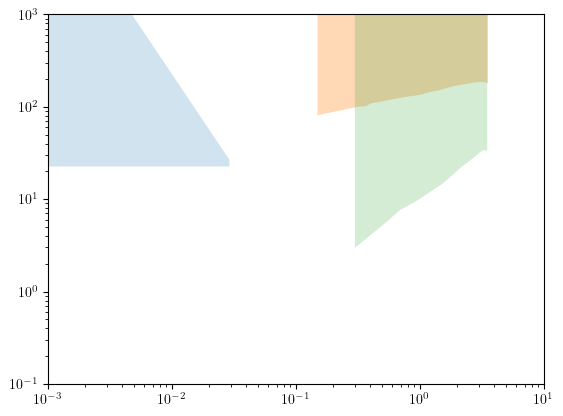

In [128]:
plt.fill_between(np.logspace(-4, np.log10(0.08), 200), low_gammainv_20fb, [coupling_length_ALP(300, ma) for ma in np.logspace(-4, np.log10(0.08), 200)], alpha=0.2)
plt.fill_between(np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200), [interp2_3gamma_20fb(ma) for ma in np.logspace(np.log10(0.15), np.log10(2e-3*mtau), 200)], 1e3, alpha=0.3)
plt.fill_between(df_taugamma20fb['ma_GeV'], df_taugamma20fb['ctau'], 1e3,label=r'$20\,\mathrm{fb}^{-1}$', alpha=0.2)


ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(0.1, 1000)
plt.xlim(1e-3, 10)